In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn
from src.data import IFCNetNumpy
from src.models.models import MeshNet
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn as nn
from sklearn.preprocessing import label_binarize

In [3]:
data_root = Path("../data/processed/MeshNet/IFCNetCore/raw")

with open("../IFCNetCore_Classes.json", "r") as f:
    class_names = json.load(f)

In [4]:
train_dataset = IFCNetNumpy(data_root, 2048, class_names, partition="train")
val_dataset = IFCNetNumpy(data_root, 2048, class_names, partition="train")
test_dataset = IFCNetNumpy(data_root, 2048, class_names, partition="test")

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.7 * len(train_dataset))
train_dataset = Subset(train_dataset, sorted(perm[:train_len]))
val_dataset = Subset(val_dataset, sorted(perm[train_len:]))

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=8)

In [5]:
model_dir = Path("../models/")
with (model_dir/"MeshNetParams.json").open("r") as f:
    config = json.load(f)

model = MeshNet(config["num_kernel"], config["sigma"], config["aggregation_method"],
                output_channels=len(class_names), require_fea=True)
model_state, _ = torch.load(model_dir/"MeshNetWeights+Optimizer")
model.load_state_dict(model_state)

<All keys matched successfully>

In [6]:
device = torch.device("cuda")
model.eval()
model.to(device)

MeshNet(
  (spatial_descriptor): SpatialDescriptor(
    (spatial_mlp): Sequential(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (structural_descriptor): StructuralDescriptor(
    (FRC): FaceRotateConvolution(
      (rotate_mlp): Sequential(
        (0): Conv1d(6, 32, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (fusion_mlp): Sequential(
        (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        (1): BatchN

In [7]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(map(lambda x: x[3:], display_labels))
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    plt.ylabel("Actual class")
    plt.xlabel("Predicted class")
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_features = []
    all_labels = []

    with torch.no_grad():
        for data, labels in tqdm(loader):
            data, labels = data.to(device), labels.to(device)

            logits, features = model(data)

            probs = F.softmax(logits, dim=1)
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())
            all_features.append(features.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    all_features = np.concatenate(all_features)
    result = calc_metrics(all_probs, all_labels)
    predictions = np.argmax(all_probs, axis=1)
    confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs, all_features

100%|██████████| 122/122 [00:16<00:00,  7.43it/s]


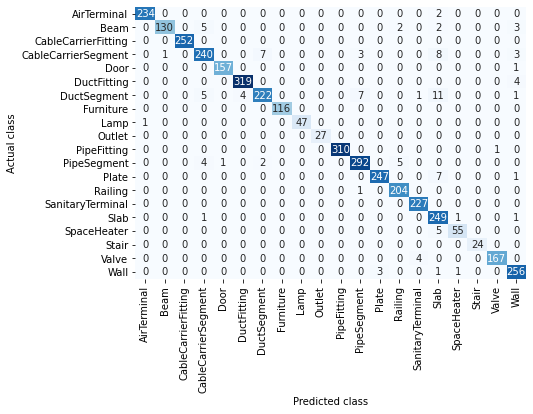

In [8]:
train_labels, train_probs, train_features = eval(model, train_loader, device, class_names)

100%|██████████| 53/53 [00:06<00:00,  7.58it/s]


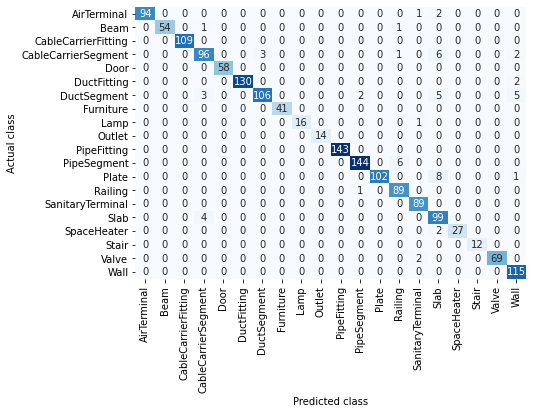

In [9]:
val_labels, val_probs, val_features = eval(model, val_loader, device, class_names)

100%|██████████| 75/75 [00:09<00:00,  7.55it/s]


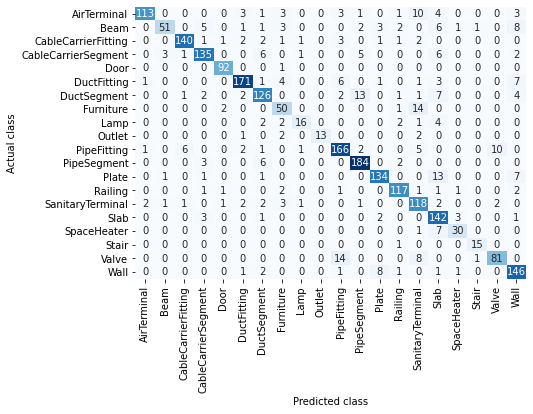

In [10]:
test_labels, test_probs, test_features = eval(model, test_loader, device, class_names)

In [11]:
test_features.shape

(2379, 256)

In [12]:
pca = PCA(n_components=50, random_state=30).fit_transform(test_features)

In [13]:
embedded = TSNE(n_components=2, random_state=35).fit_transform(pca)

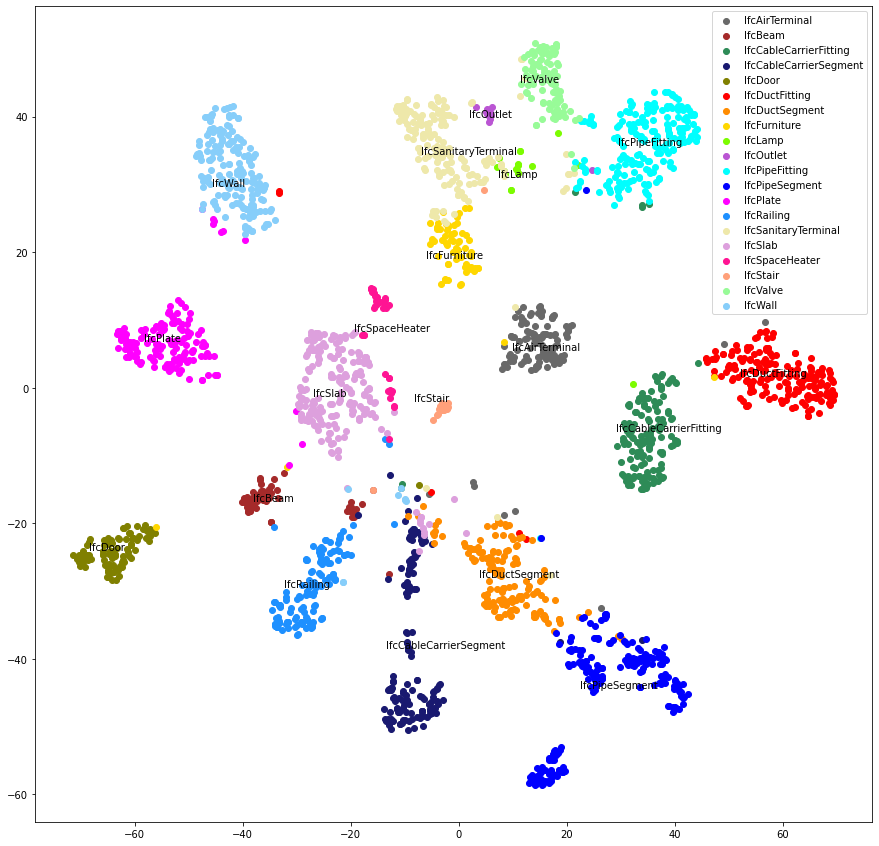

In [16]:
test_predictions = np.argmax(test_probs, axis=1)
colors = ["#696969", "#a52a2a", "#2e8b57", "#191970", "#808000", "#ff0000",
         "#ff8c00", "#ffd700", "#7cfc00", "#ba55d3", "#00ffff", "#0000ff",
         "#ff00ff", "#1e90ff", "#eee8aa", "#dda0dd", "#ff1493", "#ffa07a",
         "#98fb98", "#87cefa"]
plt.figure(figsize=(15, 15))
for i, cn in enumerate(class_names):
    points = embedded[test_predictions==i]
    cluster_center = points.mean(axis=0)
    plt.scatter(points[:, 0], points[:, 1], color=colors[i])
    plt.text(cluster_center[0]-5, cluster_center[1], cn)
plt.legend(class_names)